# Image Classification with Multi-layer Neural Network
In this computer assignment, a multi-layer neural network is trained by a given dataset. After preprocessing images and splitting them into test and train subsets, hyperparameters such as batch size, learning rate, etc., are set to provide an accurate classifier.

## Libraries
1. `matplotlib` is imported to show images and graphs.
2. `SubsetRandomSampler`, `Dataset`and `DataLoader` is imported to read and store the dataset and `transforms` to preprocess them.
3. `torch.nn.functional` is imported to use predefined activation functions.
4. `datetime` and `timedelta` is imported to record duration of training models.

In [32]:
import time
import torch
import torchvision
import numpy as np
import torch.nn as nn
from datetime import datetime
from datetime import timedelta
import torch.nn.functional as F
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.image as img 
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from IPython.display import Markdown, display
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

## Data
The given dataset consist of ... images of 52 classes. Size of each image is (3 * 80 * 60) which we use the grayscale form of them. To transform the images, I used `ToTensor` and `ToTensor_Scale` which convert a PIL Image to a tensor. `ToTensor_Scale` also normalize images and convert an image in range [0, 255] into a tensor in the range [0.0, 1.0].



In [33]:
class ToTensor(object):
    def __call__(self, image):
        image = np.array(image)
        return torch.from_numpy(image)

class ToTensor_Scale(object):
    def __call__(self, image):
        image = np.array(image)/255
        return torch.from_numpy(image)

## Part 0: Initializing
In this part, google drive is  mounted and also GPU is used to speedup the training process.

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive
# %mkdir AI_CA5
%cd AI_CA5/

dataset_path = './dataset/categorized_products'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive/AI_CA5
[Errno 2] No such file or directory: 'AI_CA5/'
/content/drive/My Drive/AI_CA5


## Part 1: Showing Samples of The Dataset
After using the above-mentioned preprocessing classes, twelve samples of dataset are shown below.

In [36]:
transform = transforms.Compose([ToTensor()])
dataset = ImageFolder(root=dataset_path, transform=transform)

class_names = dataset.classes
dataset_size = len(dataset)

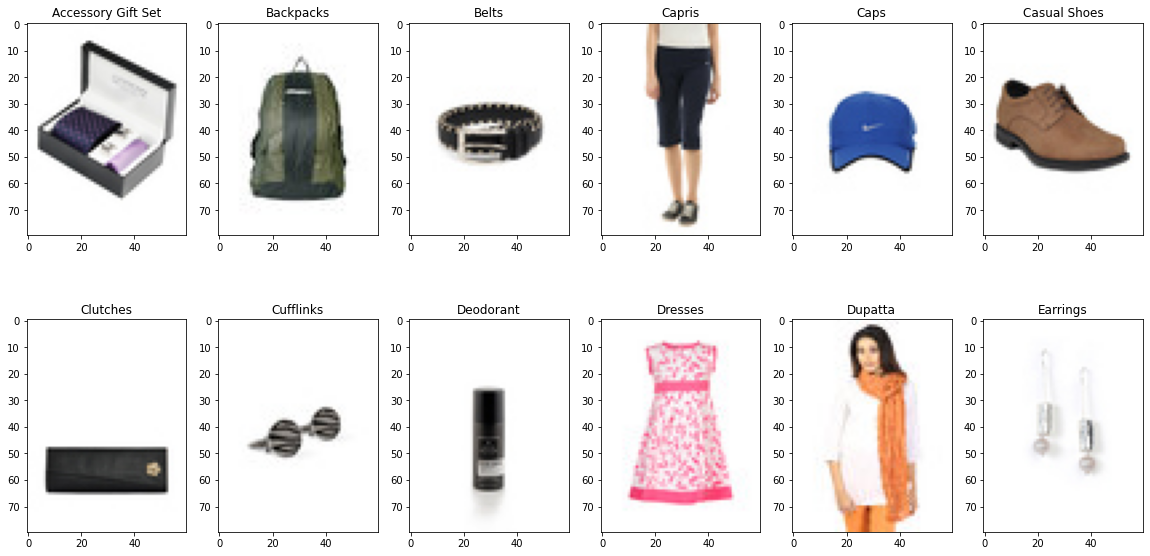

In [37]:
indices = np.arange(dataset_size, dtype=int)
images = np.array(list(map(itemgetter(0), dataset.imgs)))
labels = np.array(list(map(itemgetter(1), dataset.imgs)))

fig, axis = plt.subplots(2, 6, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
  with torch.no_grad():
    index = indices[labels == i][0]
    ax.imshow(img.imread(images[index]))
    ax.set(title = f"{class_names[i]}")

## Part 2


### 2.1. Bar Chart of Distribution of Each Class
The following chart shows the distribution of classes in the dataset which is sorted decreasingly.

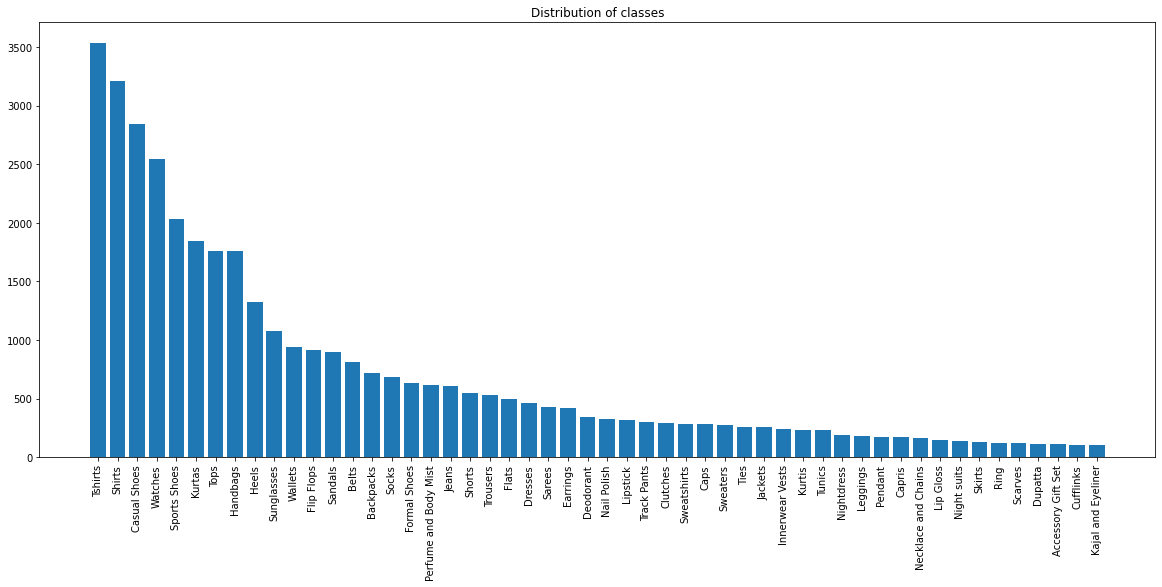

In [38]:
num_of_each_class = []

for i in range(len(dataset.classes)):
  class_indices = indices[labels == i]
  num_of_each_class.append(len(class_indices))

num_of_each_class, sorted_class_names = (list(t) for t in zip(*sorted(zip(num_of_each_class, class_names), reverse=True)))

plt.figure(figsize=[20, 8])
p1 = plt.bar(sorted_class_names, num_of_each_class)
plt.xticks(rotation='vertical')
plt.title("Distribution of classes")
plt.show()

### 2.2. Splitting Dataset Into Test and Train Sets
In the following section `split_test_and_train()` is defined which transforms, shuffles, splits images into train and test dataloaders.


In [39]:
def split_test_and_train(path, batch_size = 64, scale = True):
  if scale:
    transform = transforms.Compose([transforms.Grayscale(), ToTensor_Scale()])
  else:
    transform = transforms.Compose([transforms.Grayscale(), ToTensor()])

  dataset = ImageFolder(root = path, transform = transform)
  class_names = dataset.classes
  dataset_size = len(dataset)

  indices = np.arange(dataset_size, dtype=int)
  labels = np.array(list(map(itemgetter(1), dataset.imgs)))

  test_indices = np.array([], dtype=np.int)
  train_indices = np.array([], dtype=np.int)

  for i in range(len(dataset.classes)):
    class_indices = indices[labels == i]
    np.random.shuffle(class_indices)

    split = int(np.floor(0.2 * len(class_indices)))
    train_indices = np.concatenate((train_indices, class_indices[split:]))
    test_indices = np.concatenate((test_indices, class_indices[:split]))

  np.random.shuffle(train_indices)
  np.random.shuffle(test_indices)

  train_sampler = SubsetRandomSampler(list(train_indices))
  test_sampler = SubsetRandomSampler(list(test_indices))

  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=16)

  return train_loader, test_loader

## Part 3: Designing Multi-layer Neural Network
In this part, a five-layer neural network is designed to classify images. The numbers of layers and neurons are found using the trial and error method.

### 3.1 Number of Learnable Parameters
Our neural network consist of five layer linear layer followed by an activation function which is generally relu.



In [40]:
class Model(nn.Module):
    def __init__(self, input_size = 4800, class_num = 52, activation = F.relu):
        super(Model, self).__init__()

        self.act = activation

        self.layer1 = nn.Linear(input_size, 16 * 32 * 32)
        self.layer2 = nn.Linear(16 * 32 * 32, 32 * 16 * 16)
        self.layer3 = nn.Linear(32 * 16 * 16, 128 * 4 * 4)
        self.layer4 = nn.Linear(128 * 4 * 4, 512)
        self.layer5 = nn.Linear(512, class_num)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.act(self.layer3(x))
        x = self.act(self.layer4(x))

        x = self.layer5(x)
        return x


The following calculation shows the number of neurons in each layer:

|       |              weight            |      bias    |
|  :-:  |               :-:              |      :-:     |
|Layer 1|    4800 \* (16 \* 32 \* 32)    | 16 * 32 * 32 |
|Layer 2| (16 * 32 * 32) * (32 * 16 * 16)| 32 * 16 * 16 |
|Layer 3|     4800 \* (16 \* 32 \* 32)   | 128 * 4 * 4  |
|Layer 4| 4800 \* (16 \* 32 \* 32)       | 512          |
|Layer 5| 4800 \* (16 \* 32 \* 32)       | 52           |

The following code calculate the number of weights and biases of each layer and the total number of them which confirms the above table. 

In [41]:
model = Model()

for i, p in enumerate(model.parameters()):
  print("Layer {i} - {w_b} : {num}".format(i = i//2 + 1, w_b = "weight" if i % 2 == 0 else "bias", num = p.numel()))

total_params = sum(p.numel() for p in model.parameters())
print("Total number of learnable parameters is: {total_params}".format(total_params = total_params))

Layer 1 - weight : 78643200
Layer 1 - bias : 16384
Layer 2 - weight : 134217728
Layer 2 - bias : 8192
Layer 3 - weight : 16777216
Layer 3 - bias : 2048
Layer 4 - weight : 1048576
Layer 4 - bias : 512
Layer 5 - weight : 26624
Layer 5 - bias : 52
Total number of learnable parameters is: 230740532


### 3.2. Training the model and evaluate it


`fit()` iterates over train loader and calculates loss function based on `criterion`. Using given `optimizer`, gradient of the loss is calculated to enhance the weights. After `num_epochs` iteration, the list of loss values is returned.


In [42]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):
  total_time = 0.
  train_loss_list = np.zeros(num_epochs)

  for epoch in range(num_epochs):
      train_loss = 0.
      d1 = datetime.now()
      for images, labels in train_loader:   
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

      d2 = datetime.now()
      delta = d2 - d1
      seconds = float(delta.total_seconds())
      total_time += seconds

      train_loss_list[epoch] = train_loss / len(train_loader)

      print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, train_loss_list[epoch], seconds))
  print('total training time: %.3f minutes' % (total_time / 60))

  return train_loss_list

`calc_accuracy()` and `calc_recall()` calculate the accuracy of a model and the recall for each class. In some situation, there isn't any input predicted as a member of some classes. This being the case, the recall values of them will be `nan`.

In [43]:
def calc_accuracy(model, loader): 
    correct = 0.
    total = 0.
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images.to(device).float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()

    return 100 * correct / total

In [44]:
def calc_recall(model, loader, num_of_classes = 52):
  actual_each_class = np.zeros(num_of_classes)
  correct_predicted_each_class = np.zeros(num_of_classes)

  with torch.no_grad():
    for images, labels in loader:
      outputs = model(images.to(device).float())
      _, predicted = torch.max(outputs.data, 1)
      
      for i in range(num_of_classes):
        actual_each_class[i] += (labels == i).sum().item()
        correct_predicted_each_class[i] += ((predicted.to('cpu') == i) * (labels == i)).sum().item()

  with np.errstate(divide='ignore', invalid='ignore'):
    return correct_predicted_each_class/actual_each_class

`eval_model()` calls `fit()` to train the model and also calls `calc_accuracy()` and `calc_recall()` to calculate accuracy and recall for both test and train data.

In [45]:
def eval_model(model, train_loader, test_loader, device, criterion = nn.CrossEntropyLoss(), optimizer_method = torch.optim.SGD, batch_size = 64,
               num_epochs = 10, learning_rate = 0.01, momentum = 0, weight_decay = 0):
  
  optimizer = optimizer_method(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)
  train_loss_list = fit(model, train_loader, device, criterion, optimizer, num_epochs)

  train_acc=  calc_accuracy(model, train_loader)
  test_acc = calc_accuracy(model, test_loader)

  train_recall = calc_recall(model, train_loader)
  test_recall = calc_recall(model, test_loader)

  return train_loss_list, test_acc, train_acc, test_recall, train_recall

In [46]:
def show_loss(loss_list, title):
  fig, ax = plt.subplots()

  ax.set_xticks(np.arange(len(loss_list)))
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  ax.set_title(title)

  plt.plot(loss_list)

  plt.show()

def show_accuracy(train_acc, test_acc):
  string = "| Train Accuracy | Test Accuracy |\n" + "|:-:|:-:|\n"
  string = string + "| " + f"{train_acc:.3f}" +  "|" + f"{test_acc:.3f}" + "|\n"
  display(Markdown(string))

def show_recall(test_recall, train_recall, class_names, title):
  indices = np.arange(len(train_recall))[np.isnan(train_recall)]
  new_test_recall = np.delete(test_recall, indices)
  new_train_recall = np.delete(train_recall, indices)
  new_class_names = np.delete(class_names, indices)

  new_train_recall, new_test_recall, sorted_class_names = (list(t) for t in zip(*sorted(zip(new_train_recall, new_test_recall, new_class_names), reverse=True)))

  loc = np.arange(len(sorted_class_names))
  width = 0.35 

  fig, ax = plt.subplots(figsize=(20, 8))

  rects1 = ax.bar(loc - width/2, new_train_recall, width, label='Train')
  rects2 = ax.bar(loc + width/2, new_test_recall, width, label='Test')

  ax.set_ylabel("Recall")
  ax.set_title(title)
  ax.set_xticks(loc)
  ax.set_xticklabels(sorted_class_names)
  plt.xticks(rotation='vertical')
  ax.legend()

  plt.show()

In the following cell, the model is trained and the classification metrics, including loss values, recall and accuracy of both train and test data, are shown.

epoch 1, train_loss: nan, time elapsed: 580.258325 seconds
epoch 2, train_loss: nan, time elapsed: 57.402908 seconds
epoch 3, train_loss: nan, time elapsed: 56.901094 seconds
epoch 4, train_loss: nan, time elapsed: 57.329109 seconds
epoch 5, train_loss: nan, time elapsed: 55.436004 seconds
epoch 6, train_loss: nan, time elapsed: 55.46059 seconds
epoch 7, train_loss: nan, time elapsed: 53.507331 seconds
epoch 8, train_loss: nan, time elapsed: 54.070043 seconds
epoch 9, train_loss: nan, time elapsed: 54.222971 seconds
epoch 10, train_loss: nan, time elapsed: 55.098981 seconds
total training time: 17.995 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 0.298|0.296|


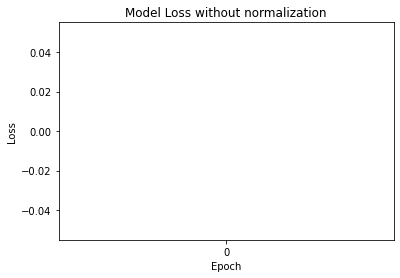

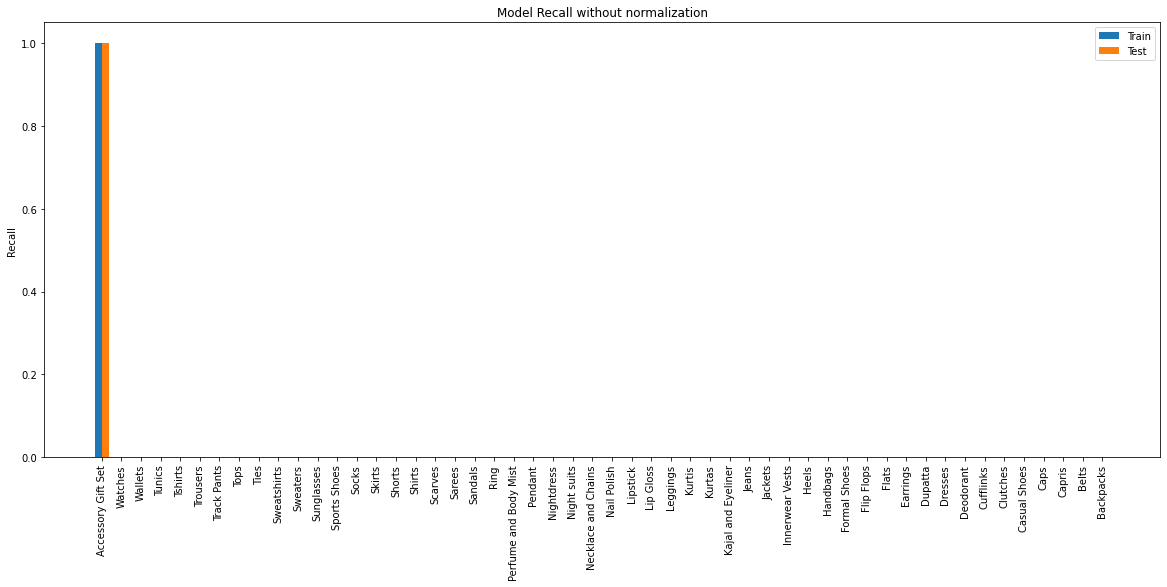

In [48]:
train_loader, test_loader = split_test_and_train(dataset_path, scale = False)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss without normalization")
show_recall(test_recall, train_recall, class_names, "Model Recall without normalization")

As we can see, the loss values of the model are converge to infinity that act like a stumbling block on the way of training the model.

## Part 4: Normalization
To improve the functionality of the model, we need to normalize the input before training the model.

epoch 1, train_loss: 3.348, time elapsed: 58.787675 seconds
epoch 2, train_loss: 2.567, time elapsed: 57.751381 seconds
epoch 3, train_loss: 2.088, time elapsed: 56.458715 seconds
epoch 4, train_loss: 1.808, time elapsed: 58.345497 seconds
epoch 5, train_loss: 1.647, time elapsed: 57.72012 seconds
epoch 6, train_loss: 1.532, time elapsed: 57.177629 seconds
epoch 7, train_loss: 1.448, time elapsed: 57.443317 seconds
epoch 8, train_loss: 1.373, time elapsed: 58.442603 seconds
epoch 9, train_loss: 1.312, time elapsed: 63.728617 seconds
epoch 10, train_loss: 1.259, time elapsed: 60.86021 seconds
total training time: 9.779 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 56.100|54.166|


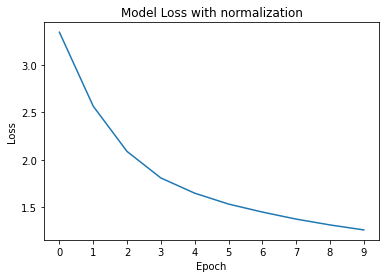

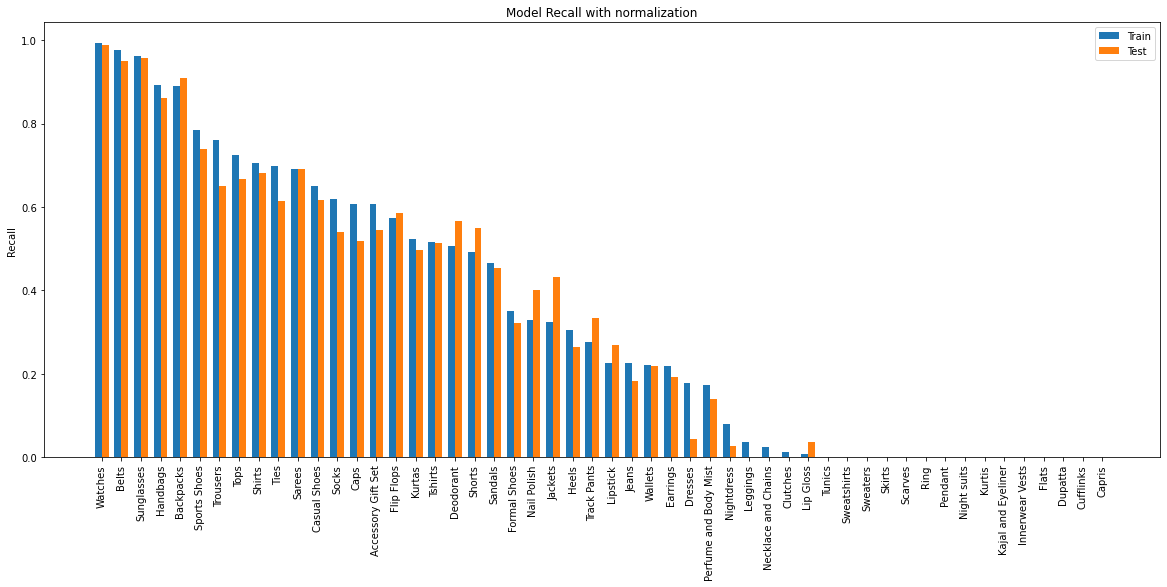

In [50]:
train_loader, test_loader = split_test_and_train(dataset_path, scale = True)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with normalization")
show_recall(test_recall, train_recall, class_names, "Model Recall with normalization")

The model trained by normalized input classifies images much better than the model trained in the previous part. Wide range of input, [0, 255], would lead to a considerable gradient which may contribute to instability and infinite loss. The second reason why normalization helps is that it keeps the mean of your data close to 0.

## Part 5: Weights Initialization



### 5.1. Initialize Weights with Zeroes
`zero_model_params` initialize all weights and biases of all layers of the model with zero.

In [51]:
def zero_model_params(model):
  nn.init.zeros_(model.layer1.bias)
  nn.init.zeros_(model.layer2.bias)
  nn.init.zeros_(model.layer3.bias)
  nn.init.zeros_(model.layer4.bias)
  nn.init.zeros_(model.layer5.bias)

  nn.init.zeros_(model.layer1.weight)
  nn.init.zeros_(model.layer2.weight)
  nn.init.zeros_(model.layer3.weight)
  nn.init.zeros_(model.layer4.weight)
  nn.init.zeros_(model.layer5.weight)

epoch 1, train_loss: 3.896, time elapsed: 55.898193 seconds
epoch 2, train_loss: 3.798, time elapsed: 54.90819 seconds
epoch 3, train_loss: 3.721, time elapsed: 55.191481 seconds
epoch 4, train_loss: 3.661, time elapsed: 55.498974 seconds
epoch 5, train_loss: 3.616, time elapsed: 55.642566 seconds
epoch 6, train_loss: 3.583, time elapsed: 56.109029 seconds
epoch 7, train_loss: 3.558, time elapsed: 56.174999 seconds
epoch 8, train_loss: 3.539, time elapsed: 55.772487 seconds
epoch 9, train_loss: 3.524, time elapsed: 55.823919 seconds
epoch 10, train_loss: 3.513, time elapsed: 55.797748 seconds
total training time: 9.280 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 9.484|9.503|


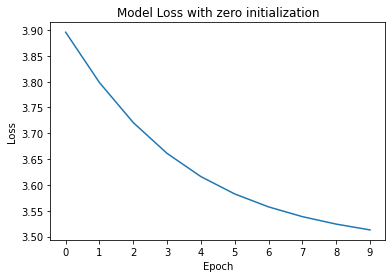

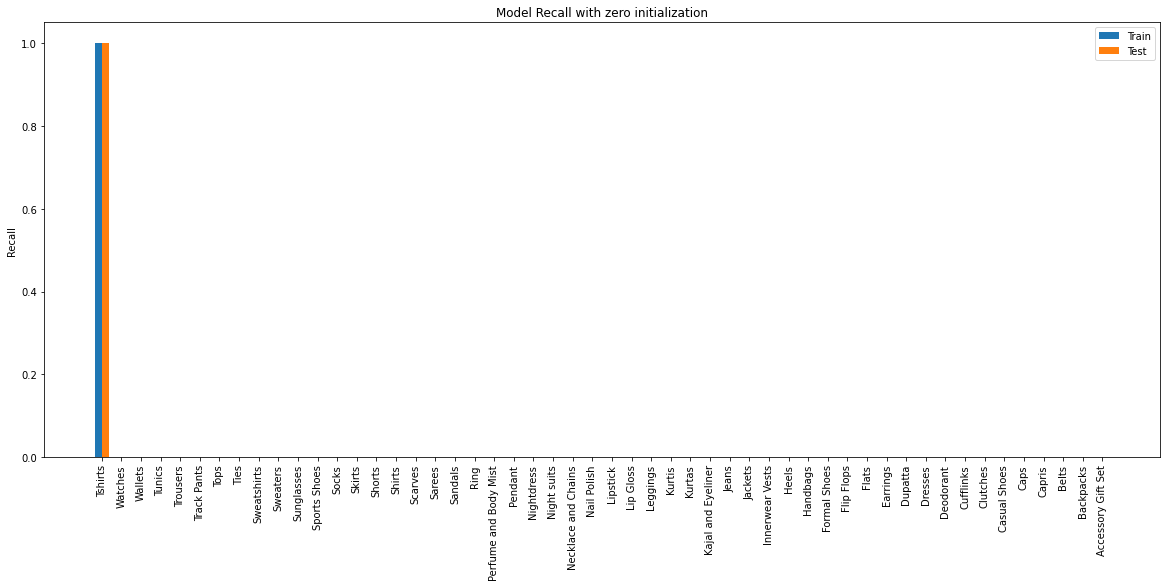

In [52]:
train_loader, test_loader = split_test_and_train(dataset_path)

model = Model()
zero_model_params(model)
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with zero initialization")
show_recall(test_recall, train_recall, class_names, "Model Recall with zero initialization")

When weights of all layers initialize by zero values, the output would be sum of the bias of the last layer. In other words, none of the weights and bias of model will be train except the biases of the last layer. Consequently, the result would be the most frequent class which is "Tshirts".


### 5.2. The Best Way to Initialize the Weights
If weights are initialized with very high values, the input of the activation function ($w^Tx + b$) would become significantly high. Consequently, the output of activation function would be saturated.(in the case of sigmoid() for high negative and positive input, and in the case of relu() for high negative input) which may decelerate training process.
 If weights are initialized with low values output of layer gets almost 0, where the case is the same as above referred as vanishing gradient.

 There are some solutions to address this problem such as He Xavier initialization. In this intializations the initial values of weights in a layer is a proportion of $(size \ of \ layer)^{-0.5}$. This means that layers with more neurons have lower initial weights.

## Part 6: Learning Rate


### 6.1. Find the Best Learning Rate
To find the best learning rate, I tried $lr = [0.01, 0.03, 0.05, 0.08, 0.1]$. According to following result the best learning rate is $0.05$.

* $lr = 0.01$


epoch 1, train_loss: 3.311, time elapsed: 58.172106 seconds
epoch 2, train_loss: 2.565, time elapsed: 59.233197 seconds
epoch 3, train_loss: 2.091, time elapsed: 59.570448 seconds
epoch 4, train_loss: 1.811, time elapsed: 58.747173 seconds
epoch 5, train_loss: 1.638, time elapsed: 56.937141 seconds
epoch 6, train_loss: 1.523, time elapsed: 55.994094 seconds
epoch 7, train_loss: 1.445, time elapsed: 56.671515 seconds
epoch 8, train_loss: 1.383, time elapsed: 56.315383 seconds
epoch 9, train_loss: 1.323, time elapsed: 57.397942 seconds
epoch 10, train_loss: 1.274, time elapsed: 57.939993 seconds
total training time: 9.616 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 59.098|58.756|


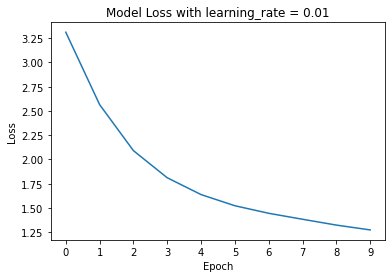

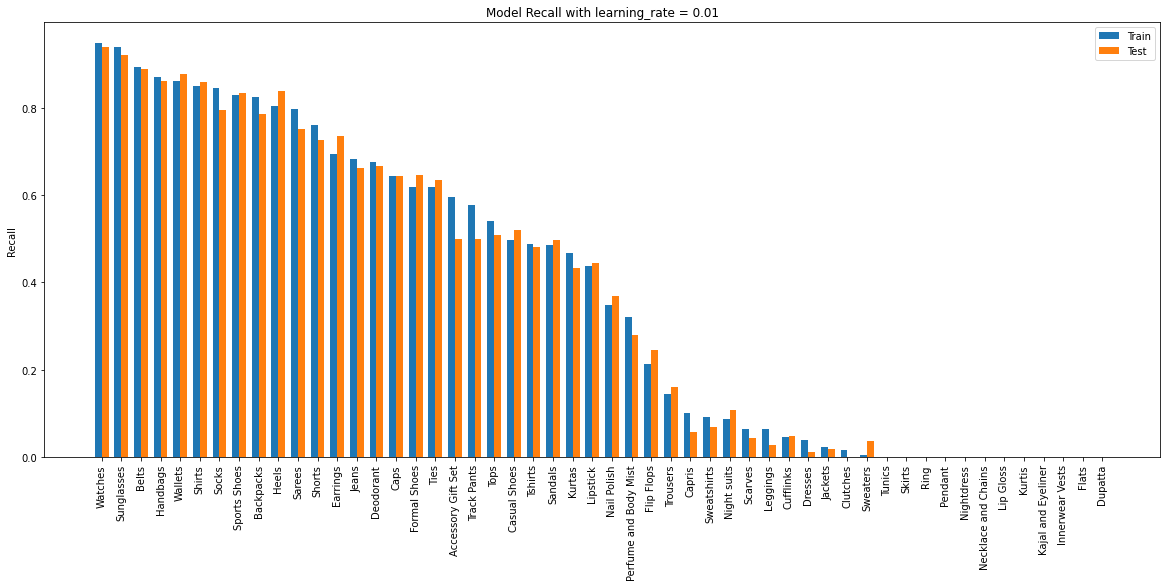

In [53]:
train_loader, test_loader = split_test_and_train(dataset_path, scale = True)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning_rate = 0.01")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning_rate = 0.01")

* $lr = 0.03$ 





epoch 1, train_loss: 2.862, time elapsed: 57.259684 seconds
epoch 2, train_loss: 1.994, time elapsed: 56.959938 seconds
epoch 3, train_loss: 1.688, time elapsed: 56.535763 seconds
epoch 4, train_loss: 1.491, time elapsed: 57.793642 seconds
epoch 5, train_loss: 1.348, time elapsed: 60.253665 seconds
epoch 6, train_loss: 1.246, time elapsed: 63.081451 seconds
epoch 7, train_loss: 1.176, time elapsed: 60.528239 seconds
epoch 8, train_loss: 1.123, time elapsed: 56.74266 seconds
epoch 9, train_loss: 1.075, time elapsed: 56.991304 seconds
epoch 10, train_loss: 1.039, time elapsed: 56.961301 seconds
total training time: 9.718 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 67.032|66.765|


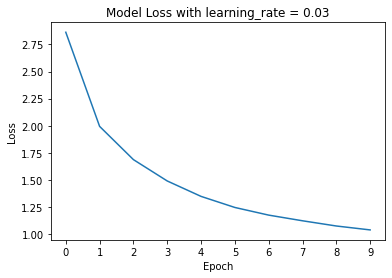

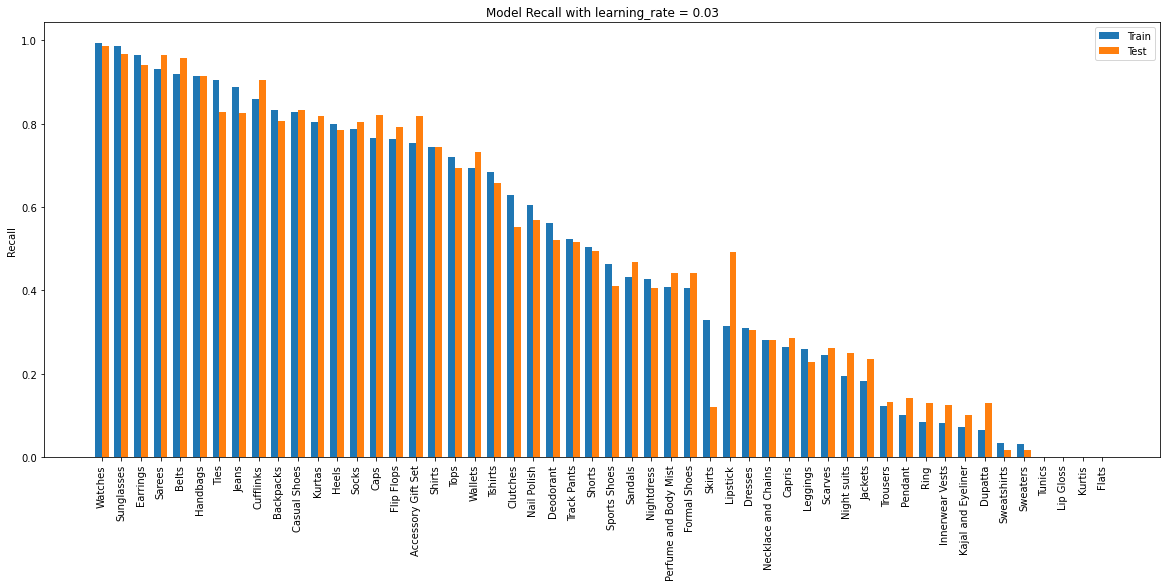

In [54]:
train_loader, test_loader = split_test_and_train(dataset_path)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.03)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning_rate = 0.03")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning_rate = 0.03")

* $lr = 0.05$ 

epoch 1, train_loss: 2.738, time elapsed: 55.519367 seconds
epoch 2, train_loss: 1.948, time elapsed: 56.936717 seconds
epoch 3, train_loss: 1.591, time elapsed: 56.852051 seconds
epoch 4, train_loss: 1.420, time elapsed: 57.013643 seconds
epoch 5, train_loss: 1.292, time elapsed: 58.07148 seconds
epoch 6, train_loss: 1.206, time elapsed: 58.875847 seconds
epoch 7, train_loss: 1.134, time elapsed: 64.37902 seconds
epoch 8, train_loss: 1.089, time elapsed: 62.488705 seconds
epoch 9, train_loss: 1.048, time elapsed: 56.627886 seconds
epoch 10, train_loss: 0.995, time elapsed: 56.937314 seconds
total training time: 9.728 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 67.773|67.304|


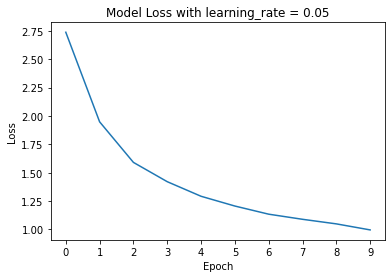

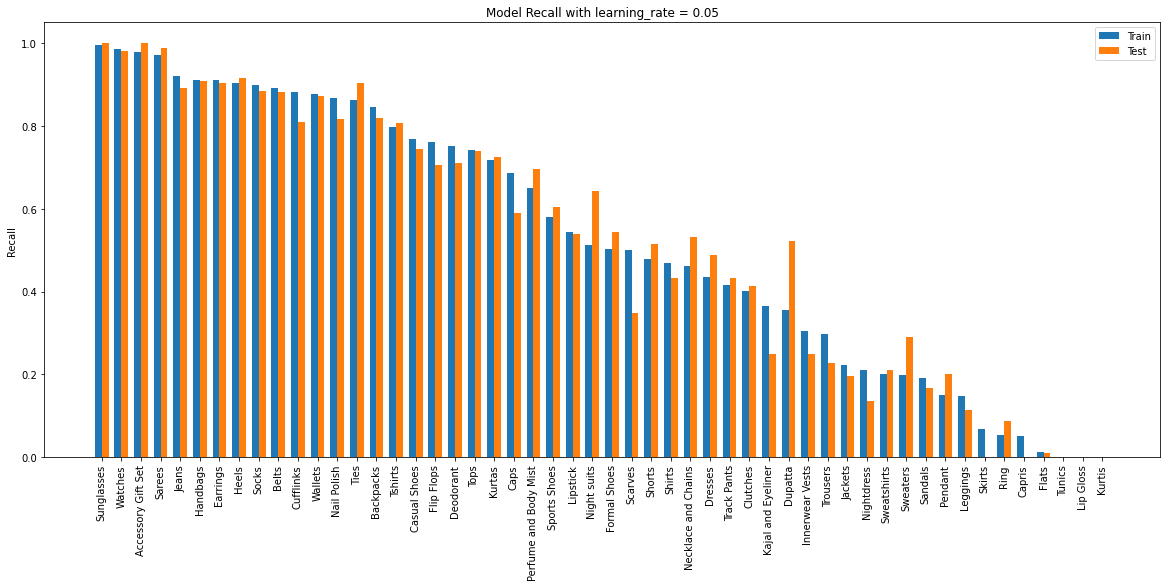

In [55]:
train_loader, test_loader = split_test_and_train(dataset_path)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.05)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning_rate = 0.05")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning_rate = 0.05")

* $lr = 0.08$ 

epoch 1, train_loss: 2.758, time elapsed: 55.997463 seconds
epoch 2, train_loss: 1.978, time elapsed: 55.445702 seconds
epoch 3, train_loss: 1.642, time elapsed: 56.118397 seconds
epoch 4, train_loss: 1.450, time elapsed: 56.818179 seconds
epoch 5, train_loss: 1.322, time elapsed: 57.317042 seconds
epoch 6, train_loss: 1.238, time elapsed: 56.99175 seconds
epoch 7, train_loss: 1.146, time elapsed: 59.597426 seconds
epoch 8, train_loss: 1.079, time elapsed: 62.705312 seconds
epoch 9, train_loss: 1.038, time elapsed: 63.942019 seconds
epoch 10, train_loss: 0.990, time elapsed: 56.729454 seconds
total training time: 9.694 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 66.362|65.702|


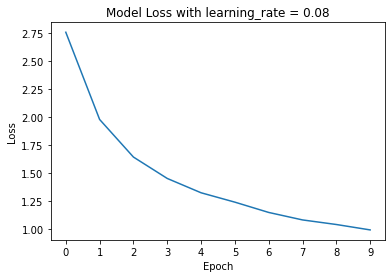

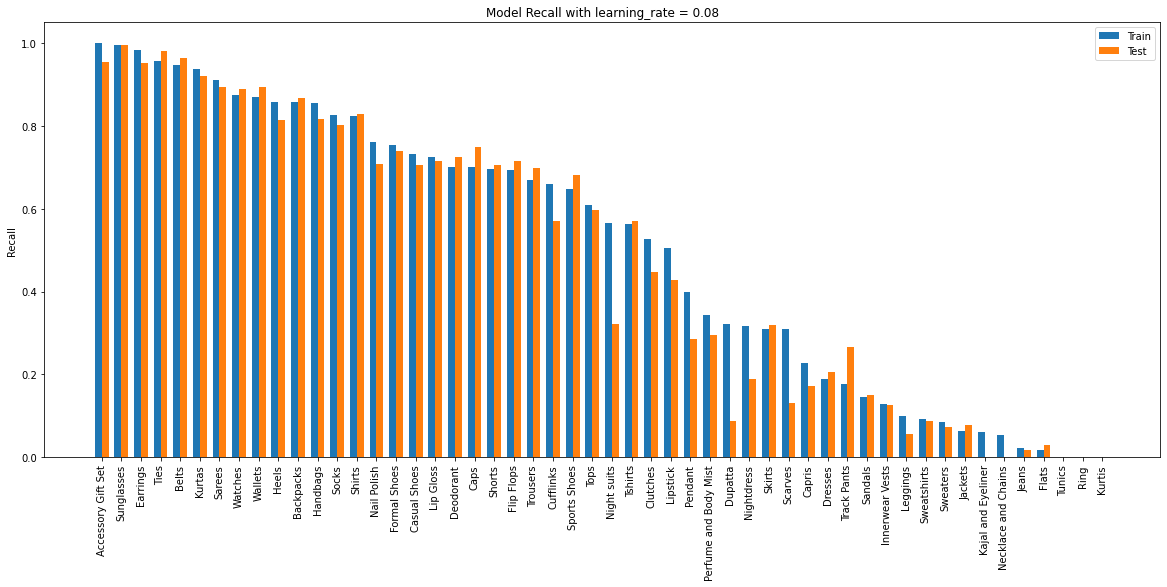

In [56]:
train_loader, test_loader = split_test_and_train(dataset_path)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.08)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning_rate = 0.08")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning_rate = 0.08")

* $lr = 0.1$

epoch 1, train_loss: 2.909, time elapsed: 57.991104 seconds
epoch 2, train_loss: 2.186, time elapsed: 56.917789 seconds
epoch 3, train_loss: 1.845, time elapsed: 56.327826 seconds
epoch 4, train_loss: 1.591, time elapsed: 57.380962 seconds
epoch 5, train_loss: 1.422, time elapsed: 57.36006 seconds
epoch 6, train_loss: 1.298, time elapsed: 56.954219 seconds
epoch 7, train_loss: 1.223, time elapsed: 63.167706 seconds
epoch 8, train_loss: 1.136, time elapsed: 57.689422 seconds
epoch 9, train_loss: 1.085, time elapsed: 57.780871 seconds
epoch 10, train_loss: 1.036, time elapsed: 57.300387 seconds
total training time: 9.648 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 66.546|66.537|


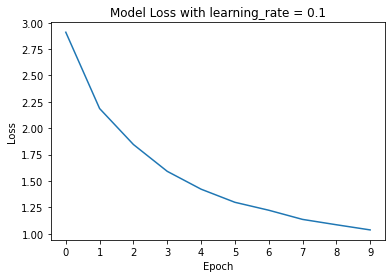

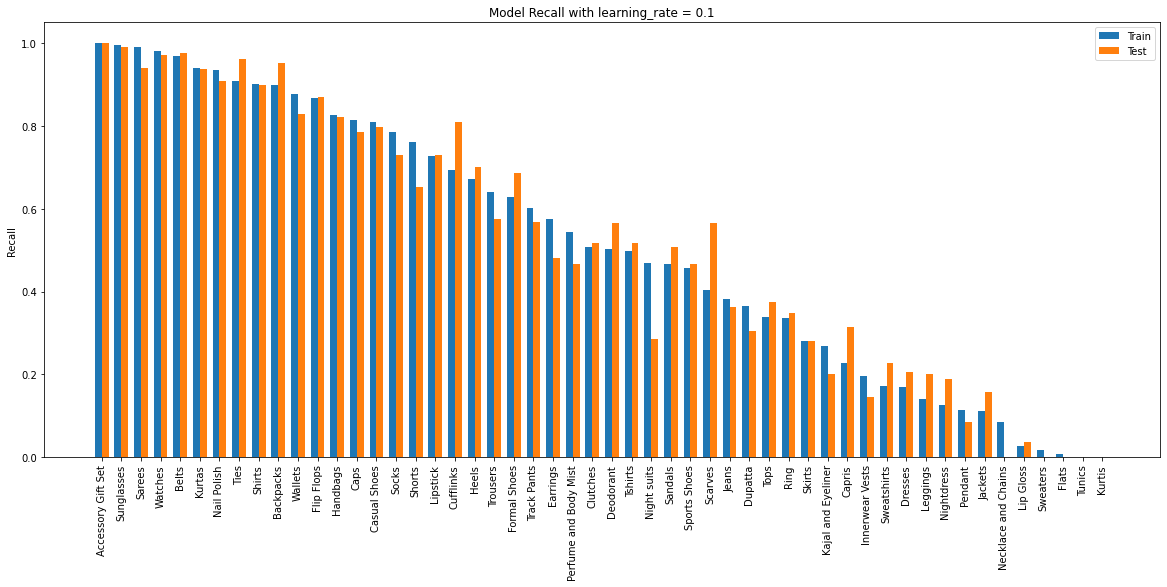

In [57]:
train_loader, test_loader = split_test_and_train(dataset_path)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.1)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning_rate = 0.1")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning_rate = 0.1")

### 6.2. Too High or Too Low Learning Rate
On the one hand, low learning rate would decrease the speed of training unreasonably, because the changes of weights are corresponds to learning rate. 
On the other hand, the gradient shows the direction of steepest descent of loss function at the point which is valid in the neighbors of that point. Therefore, high learning rate would lead to higher loss value.

A desirable learning rate is one that’s low enough so that the network converges to something useful but high enough so that it can be trained in a reasonable amount of time.

* $lr = 0.3$

epoch 1, train_loss: 3.474, time elapsed: 57.950553 seconds
epoch 2, train_loss: 3.415, time elapsed: 61.886845 seconds
epoch 3, train_loss: 3.336, time elapsed: 62.702457 seconds
epoch 4, train_loss: 3.022, time elapsed: 57.597222 seconds
epoch 5, train_loss: 2.948, time elapsed: 56.710494 seconds
epoch 6, train_loss: nan, time elapsed: 57.823612 seconds
epoch 7, train_loss: nan, time elapsed: 57.287071 seconds
epoch 8, train_loss: nan, time elapsed: 56.366591 seconds
epoch 9, train_loss: nan, time elapsed: 55.338204 seconds
epoch 10, train_loss: nan, time elapsed: 56.197667 seconds
total training time: 9.664 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 0.298|0.296|


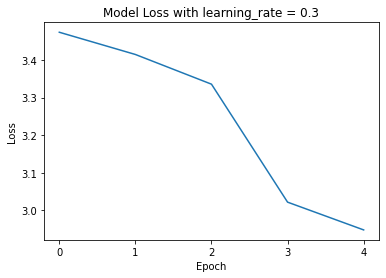

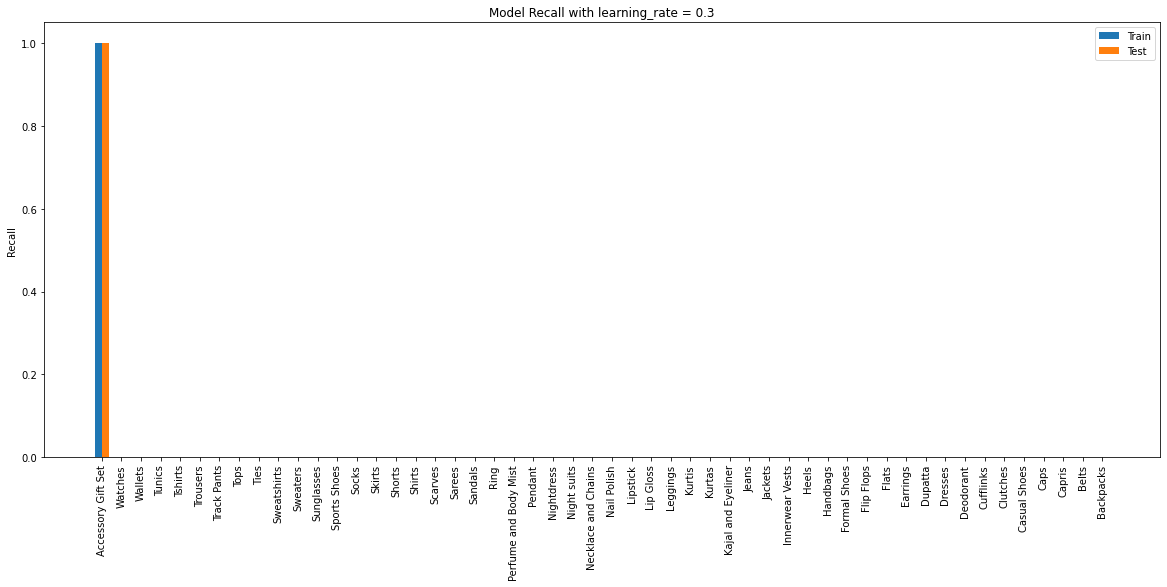

In [58]:
train_loader, test_loader = split_test_and_train(dataset_path)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.3)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning_rate = 0.3")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning_rate = 0.3")

* $lr = 0.001$

epoch 1, train_loss: 3.858, time elapsed: 56.995339 seconds
epoch 2, train_loss: 3.535, time elapsed: 58.833279 seconds
epoch 3, train_loss: 3.441, time elapsed: 63.787594 seconds
epoch 4, train_loss: 3.409, time elapsed: 62.734987 seconds
epoch 5, train_loss: 3.367, time elapsed: 57.320964 seconds
epoch 6, train_loss: 3.292, time elapsed: 57.10965 seconds
epoch 7, train_loss: 3.163, time elapsed: 56.479532 seconds
epoch 8, train_loss: 3.017, time elapsed: 57.372975 seconds
epoch 9, train_loss: 2.900, time elapsed: 60.628311 seconds
epoch 10, train_loss: 2.807, time elapsed: 58.07627 seconds
total training time: 9.822 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 24.215|24.418|


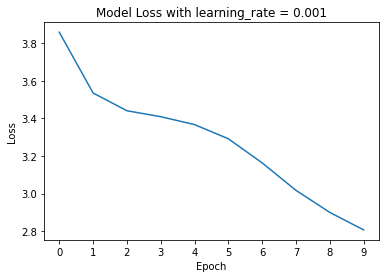

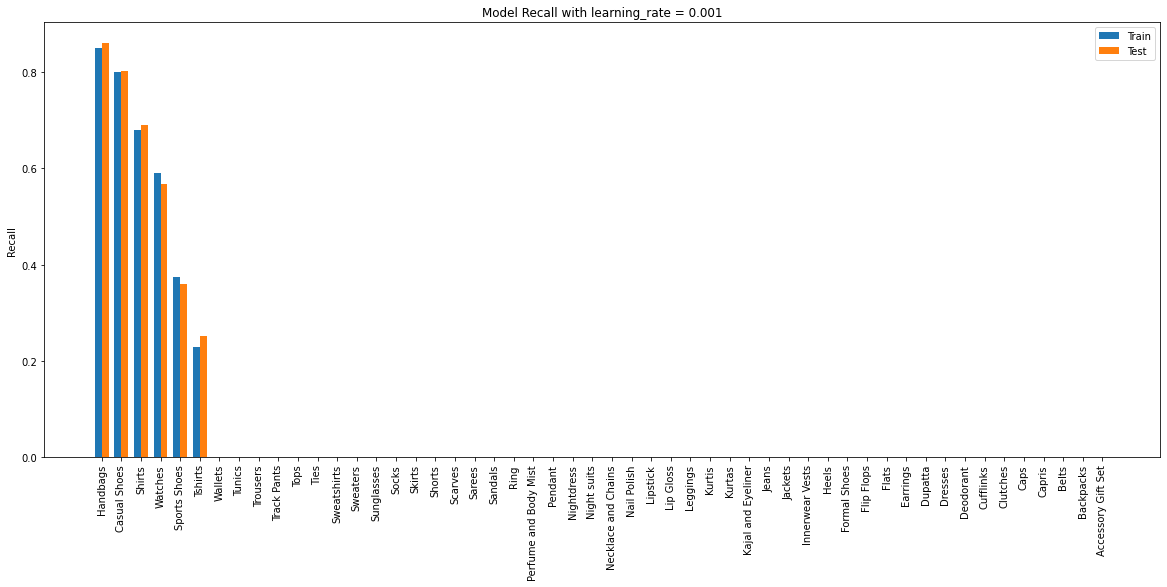

In [59]:
train_loader, test_loader = split_test_and_train(dataset_path)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.001)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning_rate = 0.001")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning_rate = 0.001")

## Part 7: Batch Size

### Part 7.1. Finding the Best Batch Size 

On the one hand, **small batch size** would decrease the time required to train each epoch. It has been empirically shown that using smaller batch sizes would lead to a faster convergence, but the drawback of using small batch size is taht the model is not guaranteed to converge the global optima.

On the other hand, **large batch** size give allows computational speedups from parallelism of GPUs. However, too large of a batch size will lead to poor generalization.

epoch 1, train_loss: 3.065, time elapsed: 54.053425 seconds
epoch 2, train_loss: 2.302, time elapsed: 54.965012 seconds
epoch 3, train_loss: 2.003, time elapsed: 56.122159 seconds
epoch 4, train_loss: 1.720, time elapsed: 58.883755 seconds
epoch 6, train_loss: 1.432, time elapsed: 53.570991 seconds
epoch 7, train_loss: 1.338, time elapsed: 54.093865 seconds
epoch 8, train_loss: 1.280, time elapsed: 54.147333 seconds
epoch 9, train_loss: 1.235, time elapsed: 53.987866 seconds
epoch 10, train_loss: 1.156, time elapsed: 54.143605 seconds
total training time: 9.248 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 63.508|62.418|


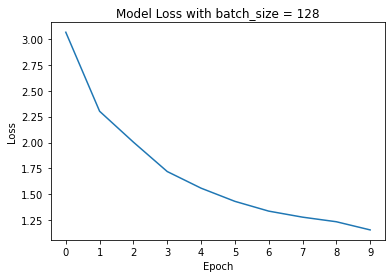

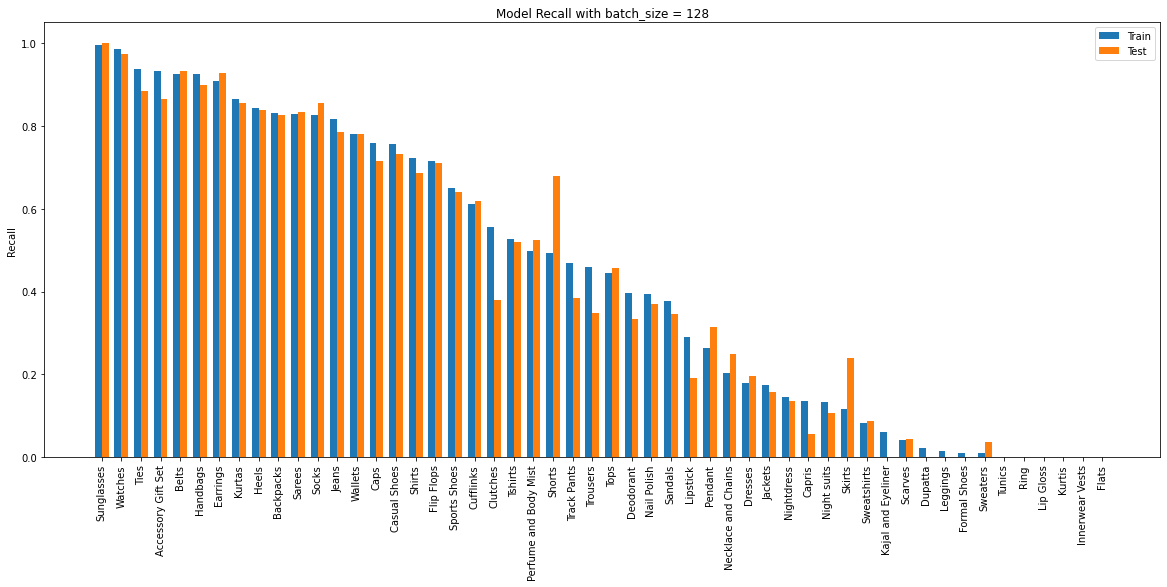

In [60]:
train_loader, test_loader = split_test_and_train(dataset_path, batch_size = 128)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.05)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with batch_size = 128")
show_recall(test_recall, train_recall, class_names, "Model Recall with batch_size = 128")

epoch 1, train_loss: 2.471, time elapsed: 78.577327 seconds
epoch 2, train_loss: 1.664, time elapsed: 78.629011 seconds
epoch 3, train_loss: 1.410, time elapsed: 78.463913 seconds
epoch 4, train_loss: 1.272, time elapsed: 79.555318 seconds
epoch 5, train_loss: 1.159, time elapsed: 79.438864 seconds
epoch 6, train_loss: 1.082, time elapsed: 78.604349 seconds
epoch 7, train_loss: 1.019, time elapsed: 78.681084 seconds
epoch 8, train_loss: 0.977, time elapsed: 78.32949 seconds
epoch 9, train_loss: 0.927, time elapsed: 78.301645 seconds
epoch 10, train_loss: 0.892, time elapsed: 78.36311 seconds
total training time: 13.116 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 67.770|66.725|


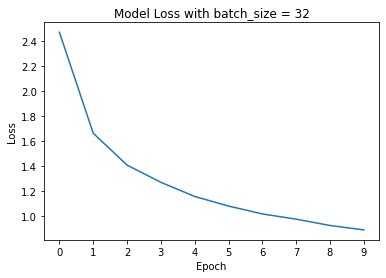

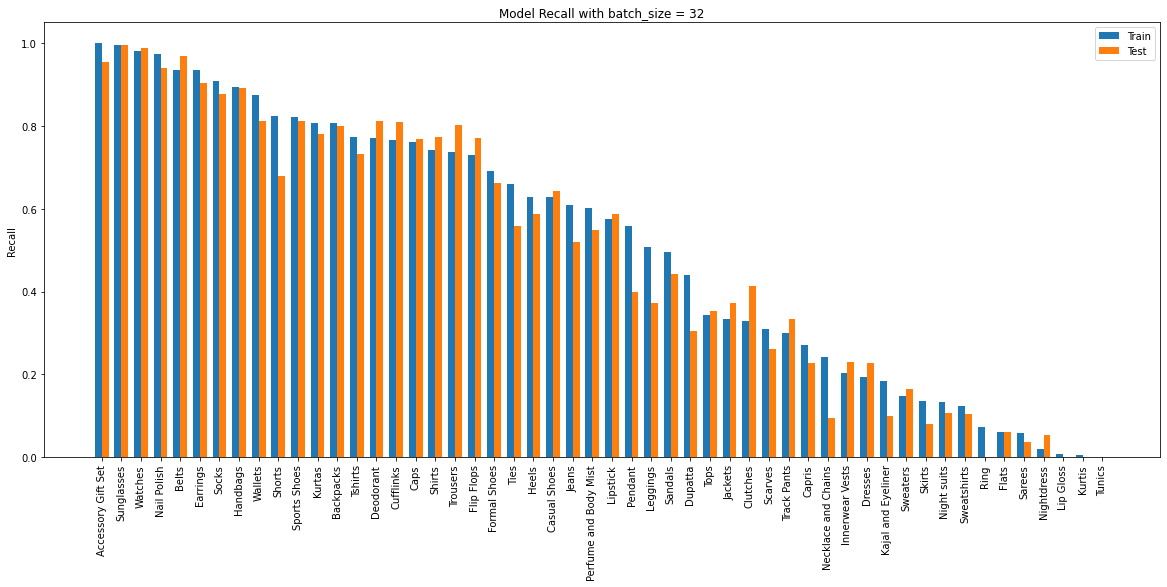

In [61]:
train_loader, test_loader = split_test_and_train(dataset_path, batch_size = 32)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.05)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with batch_size = 32")
show_recall(test_recall, train_recall, class_names, "Model Recall with batch_size = 32")

### Part 7.2. Relation between batch size and learning rate
As we can see in the following result, it's important to increase the learning rate for large batch size. Because a larger batch size would lead to a more accurate gradient which requires a larger learning rate, and vice versa.

epoch 1, train_loss: 3.532, time elapsed: 54.629913 seconds
epoch 2, train_loss: 3.105, time elapsed: 56.893329 seconds
epoch 3, train_loss: 2.710, time elapsed: 62.829938 seconds
epoch 4, train_loss: 2.417, time elapsed: 59.056861 seconds
epoch 5, train_loss: 2.166, time elapsed: 54.335011 seconds
epoch 6, train_loss: 1.982, time elapsed: 54.911311 seconds
epoch 7, train_loss: 1.836, time elapsed: 53.775168 seconds
epoch 8, train_loss: 1.728, time elapsed: 53.978611 seconds
epoch 9, train_loss: 1.651, time elapsed: 55.454213 seconds
epoch 10, train_loss: 1.572, time elapsed: 52.79164 seconds
total training time: 9.311 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 48.494|47.826|


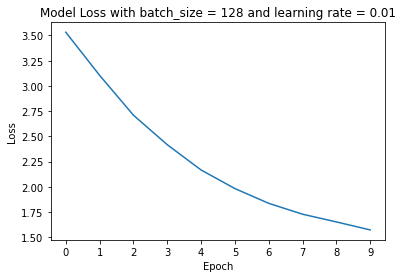

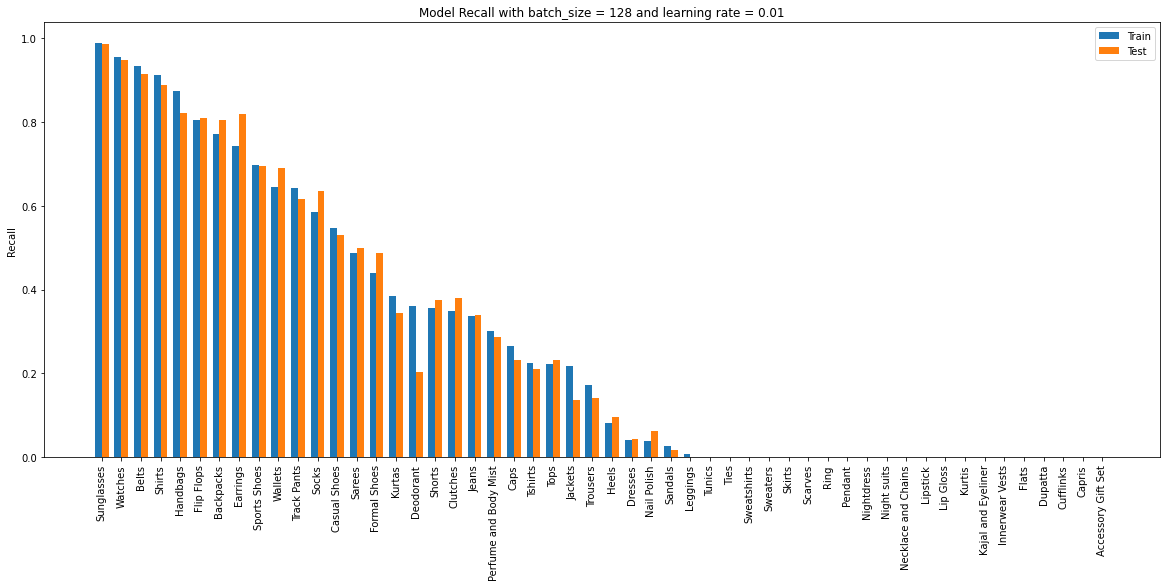

In [62]:
train_loader, test_loader = split_test_and_train(dataset_path, batch_size = 128)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.01)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with batch_size = 128 and learning rate = 0.01")
show_recall(test_recall, train_recall, class_names, "Model Recall with batch_size = 128 and learning rate = 0.01")

epoch 1, train_loss: 3.088, time elapsed: 54.053196 seconds
epoch 2, train_loss: 2.373, time elapsed: 55.372005 seconds
epoch 3, train_loss: 1.981, time elapsed: 55.155874 seconds
epoch 4, train_loss: 1.763, time elapsed: 60.268702 seconds
epoch 5, train_loss: 1.599, time elapsed: 62.952549 seconds
epoch 6, train_loss: 1.514, time elapsed: 55.350152 seconds
epoch 7, train_loss: 1.370, time elapsed: 54.472591 seconds
epoch 8, train_loss: 1.275, time elapsed: 54.372597 seconds
epoch 9, train_loss: 1.238, time elapsed: 55.357243 seconds
epoch 10, train_loss: 1.158, time elapsed: 54.498407 seconds
total training time: 9.364 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 62.803|62.337|


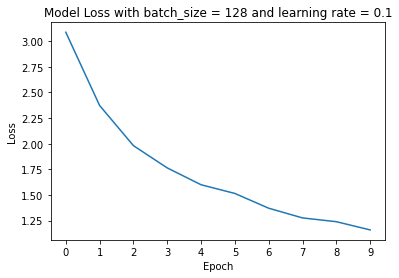

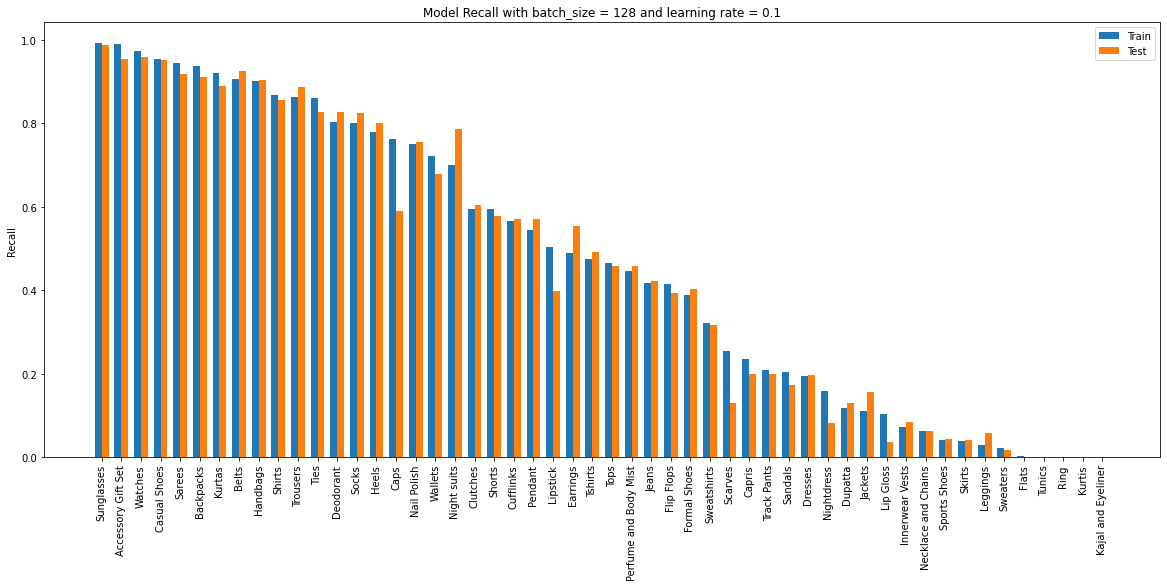

In [63]:
train_loader, test_loader = split_test_and_train(dataset_path, batch_size = 128)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.1)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with batch_size = 128 and learning rate = 0.1")
show_recall(test_recall, train_recall, class_names, "Model Recall with batch_size = 128 and learning rate = 0.1")

## Part 8: Momentum

### 8.1. What is momentum? 
Stochastic gradient descent with momentum remembers the update Δw at each iteration, and determines the next update as a linear combination of the gradient and the previous update:

$$ V_t = \mu \times V_{t-1} + \nabla L_t $$
$$ W_t = W_{t-1} - lr \times  V_t $$

Where $W_t$, $V_t$ and $\mu$ denote the weights, velocity and Coefficient of Momentum which is the percentage of the gradient retained every iteration.

With Stochastic Gradient Descent we don’t compute the exact derivate of our loss function. Instead, we’re estimating it on a small batch. Which means we’re not always going in the optimal direction, because our derivatives are ‘noisy’. Unlike in classical stochastic gradient descent, it tends to keep traveling in the same direction, preventing oscillations.

Tuning the coefficient of momentum is the main challenge of using this method. High values of the coefficient of momentum can decelerate the process of training.

### 8.2 Finding best momentum

* $momentum = 0.98$

epoch 1, train_loss: nan, time elapsed: 61.765069 seconds
epoch 2, train_loss: nan, time elapsed: 62.621053 seconds
epoch 3, train_loss: nan, time elapsed: 62.64122 seconds
epoch 4, train_loss: nan, time elapsed: 64.70684 seconds
epoch 5, train_loss: nan, time elapsed: 68.214109 seconds
epoch 6, train_loss: nan, time elapsed: 69.109059 seconds
epoch 7, train_loss: nan, time elapsed: 62.217178 seconds
epoch 8, train_loss: nan, time elapsed: 63.562429 seconds
epoch 9, train_loss: nan, time elapsed: 62.067763 seconds
epoch 10, train_loss: nan, time elapsed: 62.599267 seconds
total training time: 10.658 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 0.298|0.296|


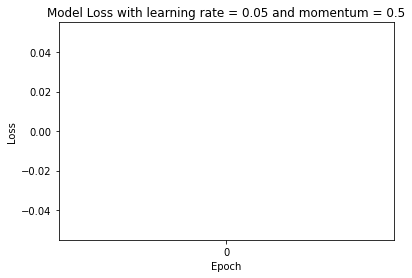

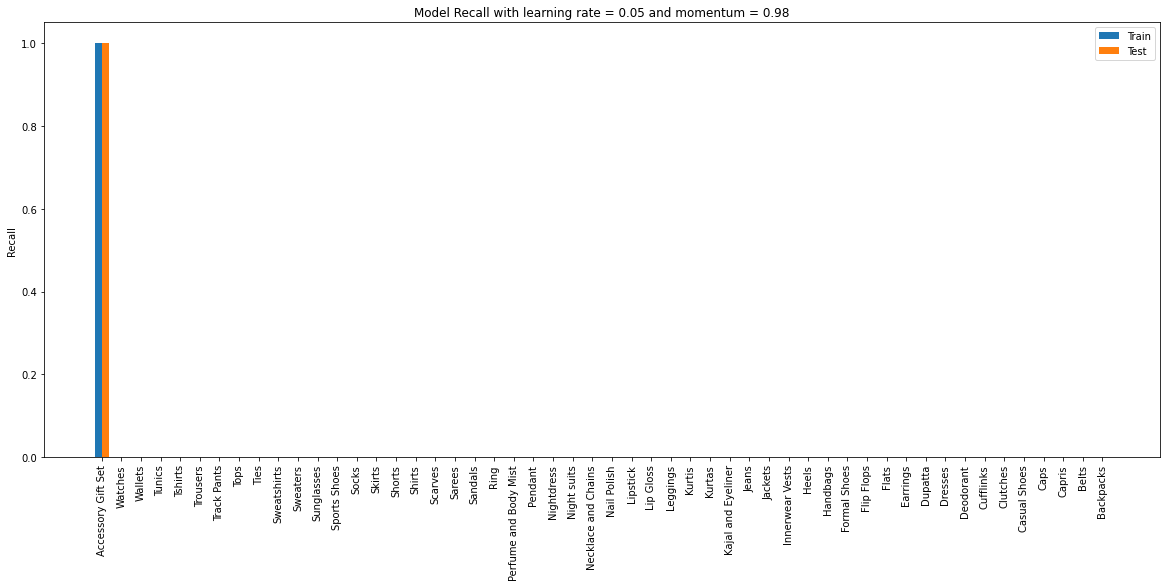

In [64]:
train_loader, test_loader = split_test_and_train(dataset_path)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.05, momentum=0.98)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning rate = 0.05 and momentum = 0.5")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning rate = 0.05 and momentum = 0.98")

* $momentum = 0.9$

epoch 1, train_loss: 2.662, time elapsed: 61.240049 seconds
epoch 2, train_loss: 2.382, time elapsed: 62.212993 seconds
epoch 3, train_loss: 2.156, time elapsed: 61.321434 seconds
epoch 4, train_loss: 1.884, time elapsed: 63.56004 seconds
epoch 5, train_loss: 1.773, time elapsed: 67.090795 seconds
epoch 6, train_loss: 1.736, time elapsed: 67.566305 seconds
epoch 7, train_loss: 1.692, time elapsed: 61.871395 seconds
epoch 8, train_loss: 1.693, time elapsed: 61.61542 seconds
epoch 9, train_loss: 1.607, time elapsed: 61.613805 seconds
epoch 10, train_loss: 1.617, time elapsed: 63.03694 seconds
total training time: 10.519 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 50.966|50.599|


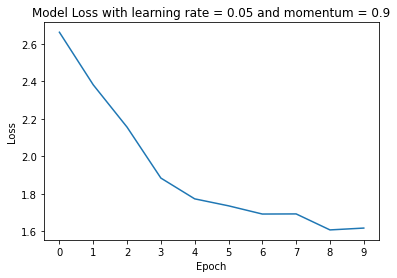

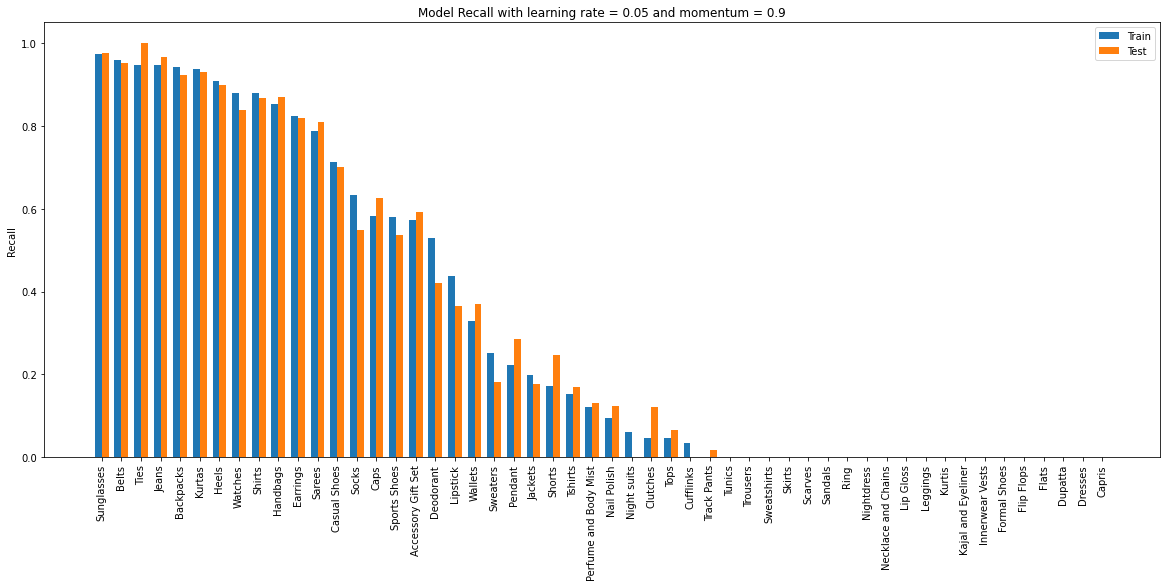

In [65]:
train_loader, test_loader = split_test_and_train(dataset_path)

model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.05, momentum=0.9)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning rate = 0.05 and momentum = 0.9")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning rate = 0.05 and momentum = 0.9")

* $momentum = 0.5$

epoch 1, train_loss: 2.649, time elapsed: 61.104397 seconds
epoch 2, train_loss: 1.793, time elapsed: 61.150903 seconds
epoch 3, train_loss: 1.486, time elapsed: 60.975124 seconds
epoch 4, train_loss: 1.327, time elapsed: 63.334893 seconds
epoch 5, train_loss: 1.199, time elapsed: 67.475993 seconds
epoch 6, train_loss: 1.118, time elapsed: 67.841905 seconds
epoch 7, train_loss: 1.062, time elapsed: 61.441902 seconds
epoch 8, train_loss: 1.004, time elapsed: 62.385501 seconds
epoch 9, train_loss: 0.963, time elapsed: 62.582445 seconds
epoch 10, train_loss: 0.911, time elapsed: 62.347012 seconds
total training time: 10.511 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 70.604|68.475|


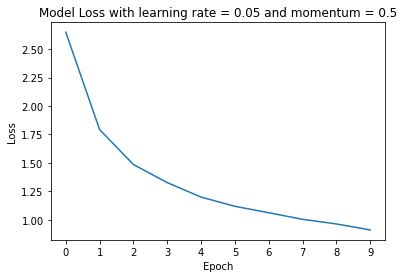

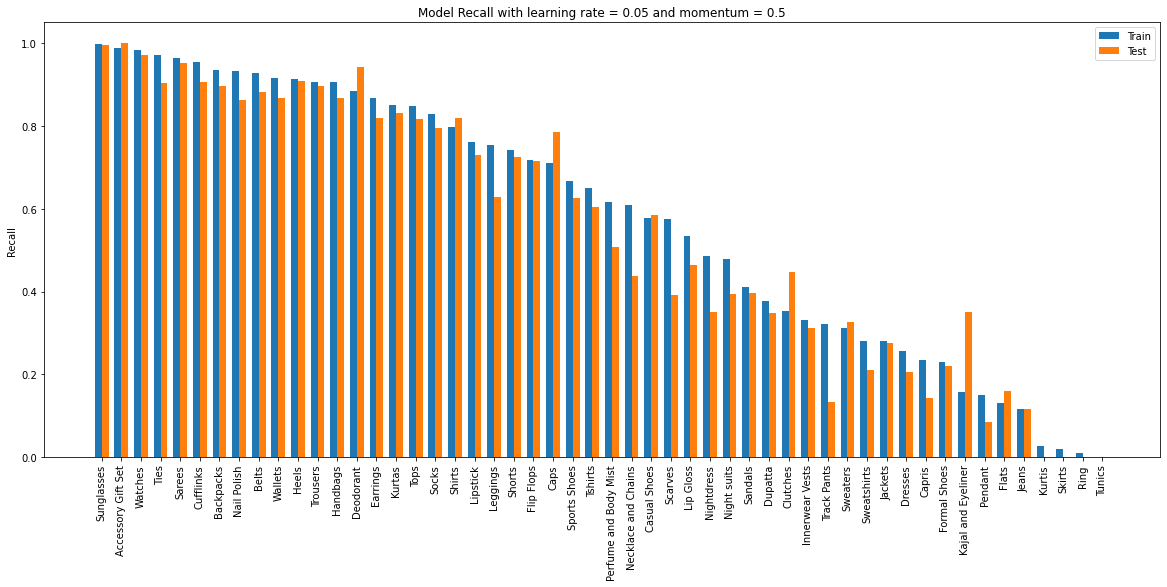

In [66]:
train_loader, test_loader = split_test_and_train(dataset_path)
 
model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.05, momentum=0.5)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning rate = 0.05 and momentum = 0.5")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning rate = 0.05 and momentum = 0.5")

Models with $momentum = 0.9 \ or \  0.98$ doesn't work well, becuase their high momentum coefficiency prevents the model to change its weights according to the gradients calculated using backward propagation method.

### 8.3. Relation between momentum and accuracy
According to the preceding result, high momentum coefficient would trivialize the terms of gradients, which would decelerate the loss reduction trend. 

## Part 9: Number of Epochs


### 9.1. Training for 20 Epochs
Following result shows that increassing the number of epochs would lead to higher accuracy. 

epoch 1, train_loss: 2.667, time elapsed: 61.502268 seconds
epoch 2, train_loss: 1.845, time elapsed: 64.46025 seconds
epoch 3, train_loss: 1.476, time elapsed: 62.24101 seconds
epoch 4, train_loss: 1.335, time elapsed: 62.095215 seconds
epoch 5, train_loss: 1.219, time elapsed: 62.831784 seconds
epoch 6, train_loss: 1.127, time elapsed: 62.414214 seconds
epoch 7, train_loss: 1.072, time elapsed: 61.826321 seconds
epoch 8, train_loss: 1.006, time elapsed: 61.849472 seconds
epoch 9, train_loss: 0.964, time elapsed: 62.31047 seconds
epoch 10, train_loss: 0.930, time elapsed: 61.862966 seconds
epoch 11, train_loss: 0.886, time elapsed: 63.212046 seconds
epoch 12, train_loss: 0.859, time elapsed: 65.773722 seconds
epoch 13, train_loss: 0.830, time elapsed: 69.471921 seconds
epoch 14, train_loss: 0.797, time elapsed: 62.796878 seconds
epoch 15, train_loss: 0.782, time elapsed: 62.613577 seconds
epoch 16, train_loss: 0.755, time elapsed: 61.848504 seconds
epoch 17, train_loss: 0.733, time el

| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 76.429|72.903|


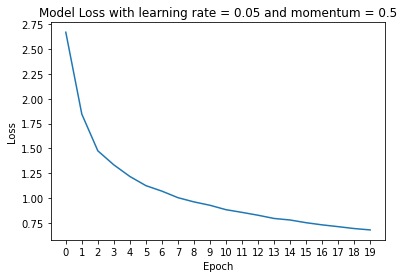

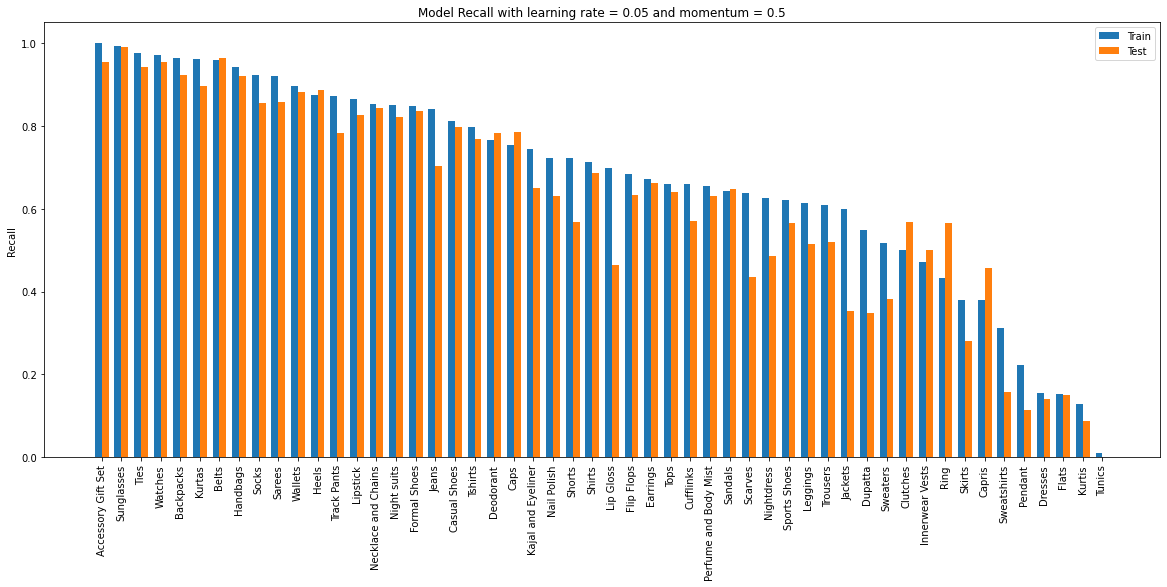

In [67]:
train_loader, test_loader = split_test_and_train(dataset_path)
 
model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, num_epochs = 20, learning_rate= 0.05,
                                                                             momentum=0.5)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning rate = 0.05 and momentum = 0.5")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning rate = 0.05 and momentum = 0.5")

### 9.2. Why Training for more than one epoch is necessary?
Because of the stochastic nature of batch gradient descent and the limitation of data for training a model, It is necessary to pass the entire dataset through a neural network more than one time. 

### 9.3. Number of Epochs and Overfitting
As the number of epochs increases, the curve goes from underfitting to optimal to overfitting curve. If the numbers of epochs increase significantly, the model would memorize the input and lose its generalization.

## Part 10: Activation Fucntion
According the following results, a model with Relu activation function is better than the one with Leaky Relu activation function, but a model with Tanh activation function is the most accurate one.

* Leaky Relu

epoch 1, train_loss: 2.590, time elapsed: 63.715112 seconds
epoch 2, train_loss: 1.780, time elapsed: 65.269328 seconds
epoch 3, train_loss: 1.555, time elapsed: 69.091852 seconds
epoch 4, train_loss: 1.317, time elapsed: 70.051455 seconds
epoch 5, train_loss: 1.199, time elapsed: 62.642931 seconds
epoch 6, train_loss: 1.171, time elapsed: 63.348239 seconds
epoch 7, train_loss: 1.070, time elapsed: 62.249523 seconds
epoch 8, train_loss: 1.009, time elapsed: 64.292546 seconds
epoch 9, train_loss: 0.965, time elapsed: 63.219803 seconds
epoch 10, train_loss: 0.921, time elapsed: 63.006708 seconds
total training time: 10.781 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 66.516|64.275|


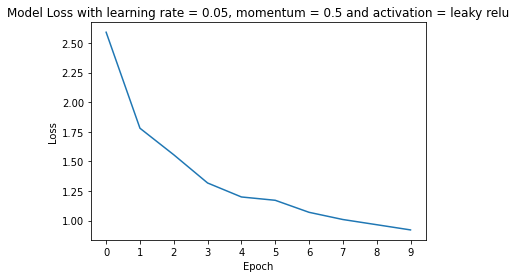

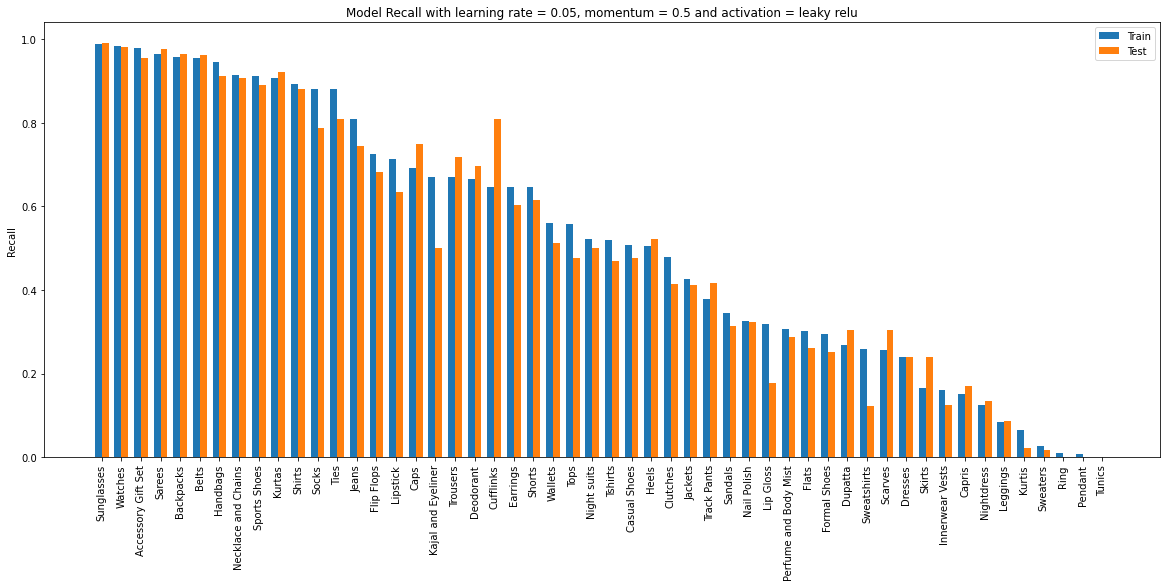

In [68]:
train_loader, test_loader = split_test_and_train(dataset_path)
 
model = Model(activation=F.leaky_relu)
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.05, momentum=0.5)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning rate = 0.05, momentum = 0.5 and activation = leaky relu")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning rate = 0.05, momentum = 0.5 and activation = leaky relu")

* Tanh

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1, train_loss: 1.990, time elapsed: 63.683632 seconds
epoch 2, train_loss: 1.377, time elapsed: 61.89709 seconds
epoch 3, train_loss: 1.199, time elapsed: 62.634942 seconds
epoch 4, train_loss: 1.088, time elapsed: 62.68124 seconds
epoch 5, train_loss: 1.020, time elapsed: 62.360618 seconds
epoch 6, train_loss: 0.953, time elapsed: 63.667186 seconds
epoch 7, train_loss: 0.910, time elapsed: 64.226184 seconds
epoch 8, train_loss: 0.865, time elapsed: 64.126818 seconds
epoch 9, train_loss: 0.832, time elapsed: 64.211556 seconds
epoch 10, train_loss: 0.805, time elapsed: 63.878615 seconds
total training time: 10.556 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 70.681|68.663|


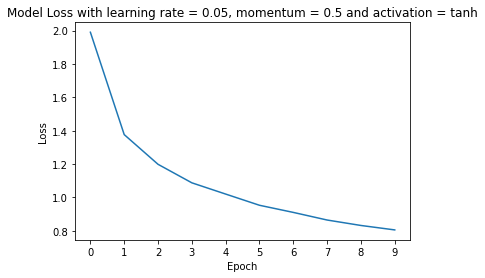

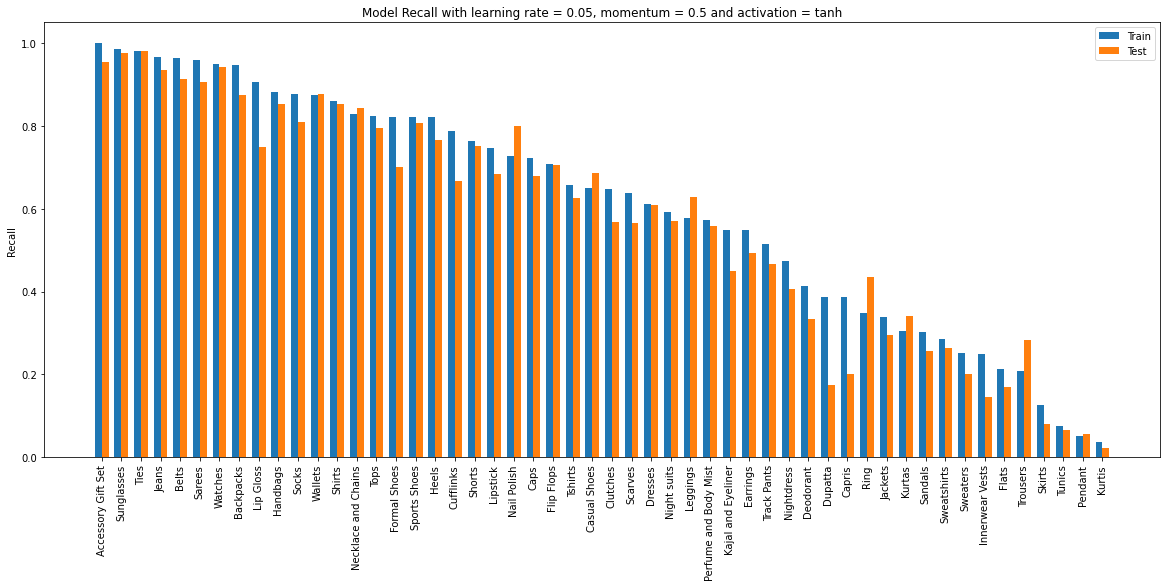

In [69]:
train_loader, test_loader = split_test_and_train(dataset_path)
 
model = Model(activation=F.tanh)
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.05, momentum=0.5)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning rate = 0.05, momentum = 0.5 and activation = tanh")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning rate = 0.05, momentum = 0.5 and activation = tanh")

## Part 11: Regularization

### 11.1. How Regularization Prevent Overfitting?
As we know, the larger the parameters of a model become, the higher the chance the model overfits the data. So adding the term $L_{reg} = \frac{\lambda}{2m}\sum_{j=1}^n |W|_{j}^2$ to the MSE term ,where n is the number of layers in the model, would penalizes large parameters. 

$$ L = L_{MSE} + L_{reg} = \frac{1}{2m}\sum_{i=1}^m (\hat{y} - y)^2 + \frac{\lambda}{2m}\sum_{j=1}^n |W|_{j}^2$$

In the other words, minimizing the cost function consists of reducing MSE term and the regularization term simultaneously.

### 11.2. How weight decay method regularize the model?
As you can see in the following equation, the weight decay term plays the role of the regulation term in the loss equation. 

$$ L = L_{MSE} + \frac{\lambda}{2}|W|^2  \to \nabla L = \nabla L_{MSE} + \lambda W$$

$$ W = W - lr \times \nabla L = (1 - \lambda \times lr) W - lr \times \nabla L_{MSE}$$

where weight decay coefficient is $\lambda \times lr$

### 11.3. weight decay = 0.1
According to the following result, the training process is disturbed by high weight decay. 

epoch 1, train_loss: 3.458, time elapsed: 68.234504 seconds
epoch 2, train_loss: 3.386, time elapsed: 68.39204 seconds
epoch 3, train_loss: 3.376, time elapsed: 68.411162 seconds
epoch 4, train_loss: 3.376, time elapsed: 68.495835 seconds
epoch 5, train_loss: 3.384, time elapsed: 68.88615 seconds
epoch 6, train_loss: 3.373, time elapsed: 68.433019 seconds
epoch 7, train_loss: 3.381, time elapsed: 68.226323 seconds
epoch 8, train_loss: 3.380, time elapsed: 68.463644 seconds
epoch 9, train_loss: 3.379, time elapsed: 68.306442 seconds
epoch 10, train_loss: 3.383, time elapsed: 68.520326 seconds
total training time: 11.406 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 9.480|9.503|


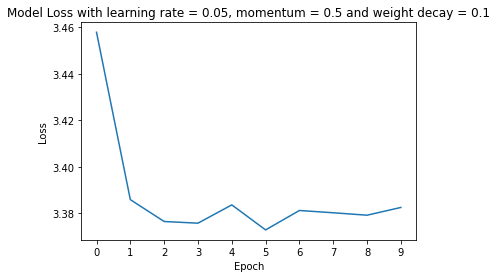

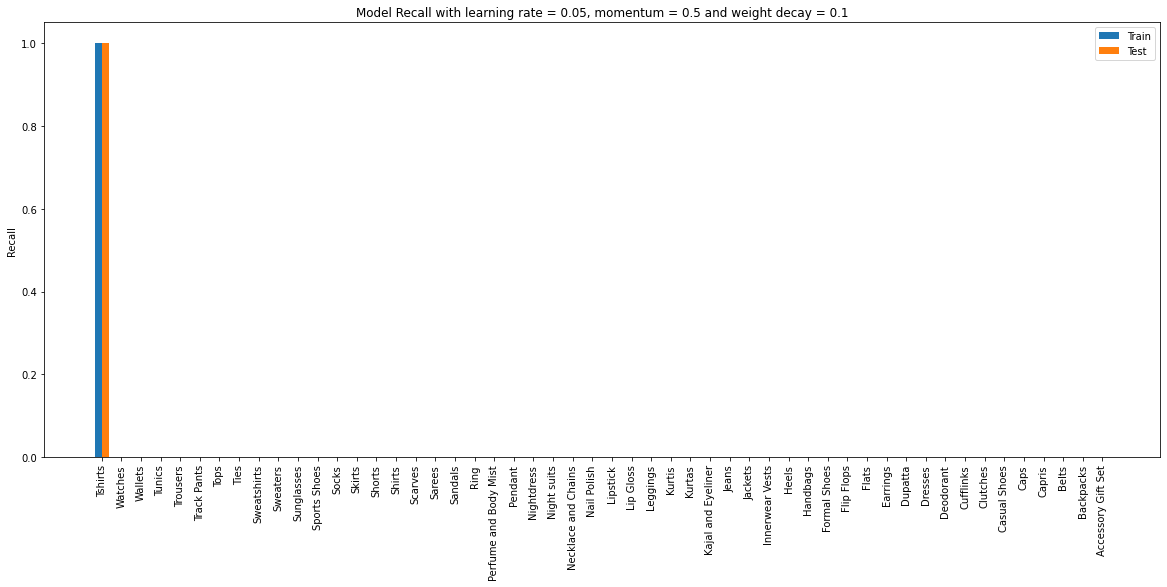

In [70]:
train_loader, test_loader = split_test_and_train(dataset_path)
 
model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.05, momentum=0.5,
                                                                             weight_decay = 0.1)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning rate = 0.05, momentum = 0.5 and weight decay = 0.1")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning rate = 0.05, momentum = 0.5 and weight decay = 0.1")

### 11.4. weight decay = 0.01


The model of part 8 has the better result in comparison to the models with with weight decay = 0.1 or 0.01. The reason behind this failure is the high value of weight decay in these models. This insufficiency shows the importance of tunning the weight decay hyperparameter in training a model in order to reduce ovefitting.

epoch 1, train_loss: 2.633, time elapsed: 68.018185 seconds
epoch 2, train_loss: 2.008, time elapsed: 68.445914 seconds
epoch 3, train_loss: 1.892, time elapsed: 68.181108 seconds
epoch 4, train_loss: 1.845, time elapsed: 68.484297 seconds
epoch 5, train_loss: 1.830, time elapsed: 68.938915 seconds
epoch 6, train_loss: 1.787, time elapsed: 68.380954 seconds
epoch 7, train_loss: 1.746, time elapsed: 68.736933 seconds
epoch 8, train_loss: 1.851, time elapsed: 68.192961 seconds
epoch 9, train_loss: 1.782, time elapsed: 68.159916 seconds
epoch 10, train_loss: 1.763, time elapsed: 68.722368 seconds
total training time: 11.404 minutes


| Train Accuracy | Test Accuracy |
|:-:|:-:|
| 48.444|48.755|


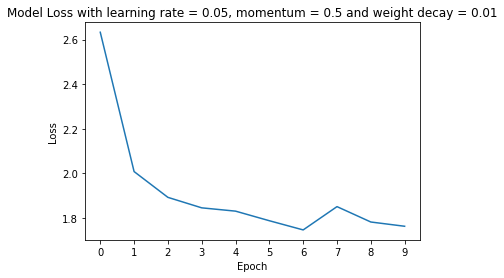

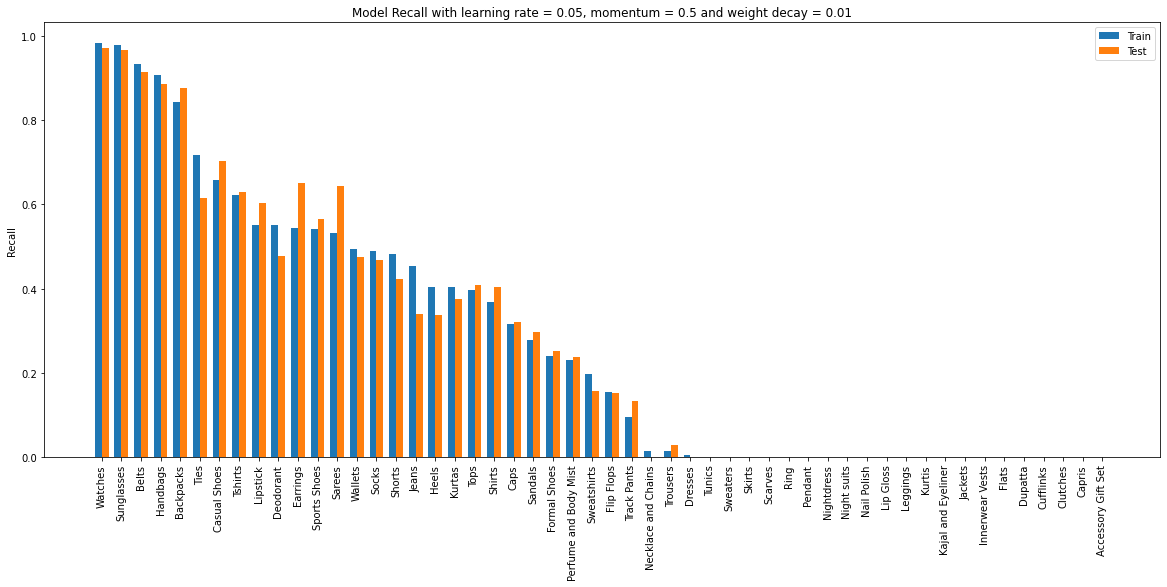

In [71]:
train_loader, test_loader = split_test_and_train(dataset_path)
 
model = Model()
model = model.to(device)
train_loss_list, test_acc, train_acc, test_recall, train_recall = eval_model(model, train_loader, test_loader, device, learning_rate= 0.05, momentum=0.5,
                                                                             weight_decay = 0.01)

show_accuracy(train_acc, test_acc)
show_loss(train_loss_list, "Model Loss with learning rate = 0.05, momentum = 0.5 and weight decay = 0.01")
show_recall(test_recall, train_recall, class_names, "Model Recall with learning rate = 0.05, momentum = 0.5 and weight decay = 0.01")